In [96]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [230]:
def kmean(X: np.ndarray, k, distance_fn, init_centers: np.ndarray = None, loops = 1000):
  old_centers = None
  if init_centers is None:
    old_centers = X[np.random.choice(X.shape[0], size=k, replace=False), :].copy()
  else:  
    old_centers = init_centers.copy()
  print(old_centers)
  old_lables = []
  for i in range(loops):
    new_labels = []
    for x in X:
      new_labels.append(np.argmin([distance_fn(x, c) for c in old_centers]))

    

    new_centers = np.zeros((k, X.shape[1]), dtype=float)
    count = np.zeros(k)
    for i, x in enumerate(X):
      new_centers[new_labels[i]] += x
      count[new_labels[i]] += 1

    for i, c in enumerate(new_centers):
      new_centers[i] /= count[i]

    if (old_centers == new_centers).all():
      old_centers = new_centers
      old_lables = new_labels
      break

    old_centers = new_centers
    old_lables = new_labels

  return np.array(old_lables), old_centers


In [64]:
def euclidean(x: np.ndarray, y: np.ndarray):
  return np.linalg.norm(x - y, 2, 0)

In [228]:
X = np.array([
  [3, 0],
  [3.2, 0],
  [4, 0],
  [4, 4],
  [4.2, 4.2],
  [0, 4.2],
  [0, 4],
])

In [243]:
X = pd.read_csv("data.csv", header=None)
X.columns = ["x", "y"]
X_data = X.to_numpy()


[[379.10199   66.117996]
 [419.109009  87.422997]
 [453.920013  82.330002]]
[[147.78915805  81.74157136]
 [416.69598889  78.05277547]
 [674.99182243  81.16388389]]
[0 1 2]


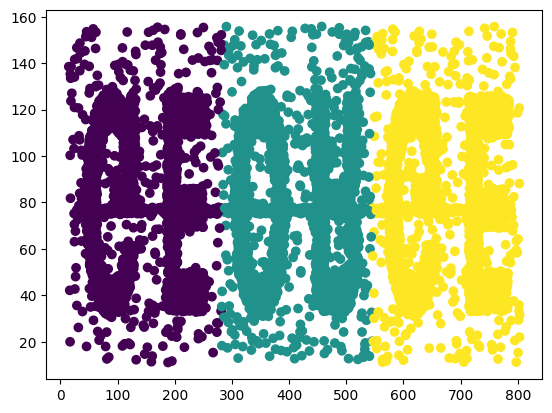

In [246]:
labels, centers = kmean(X_data, 3, euclidean)
print(centers)
print(np.unique(labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")